In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv('customer_data.csv')

In [5]:
print("Summary Statistics:")
print(data.describe())

Summary Statistics:
               Age  MonthlyCharges  TotalCharges       Tenure  \
count  5000.000000     5000.000000   5000.000000  5000.000000   
mean     49.564600       68.307897   1624.493352    24.015600   
std      11.846683       28.322337   1550.618525    19.622486   
min      18.000000       30.013471     30.500000     1.000000   
25%      42.000000       49.407109    531.787500     9.000000   
50%      50.000000       62.530015   1115.450000    18.000000   
75%      57.000000       79.556421   2230.665000    37.000000   
max      80.000000      337.450517  14699.630000    71.000000   

       AverageMonthlyCharges  CustomerLifetimeValue  
count            5000.000000            5000.000000  
mean               68.307897            1570.205934  
std                28.322337            1455.807294  
min                30.013471              30.500000  
25%                49.407109             523.475000  
50%                62.530015            1094.700000  
75%             

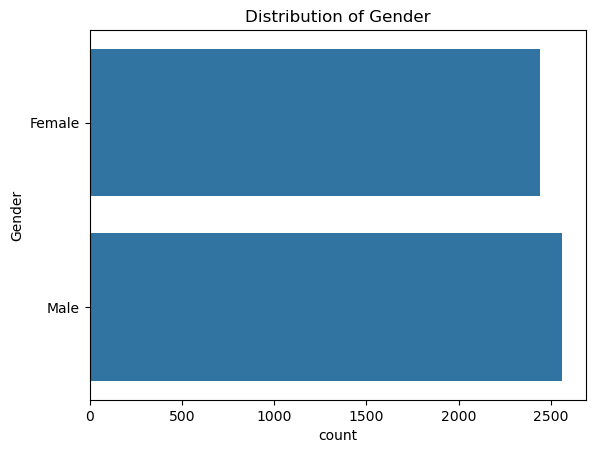

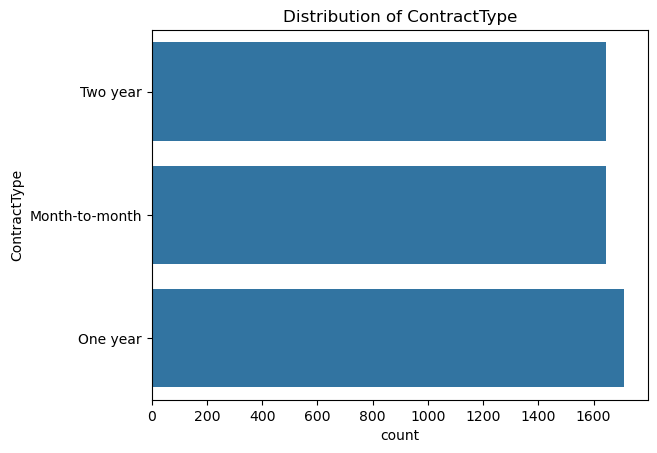

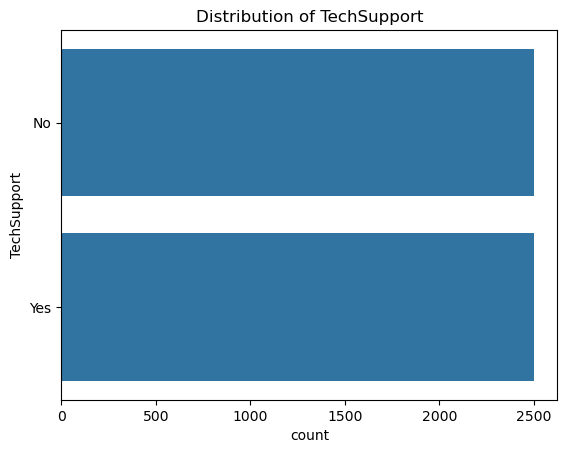

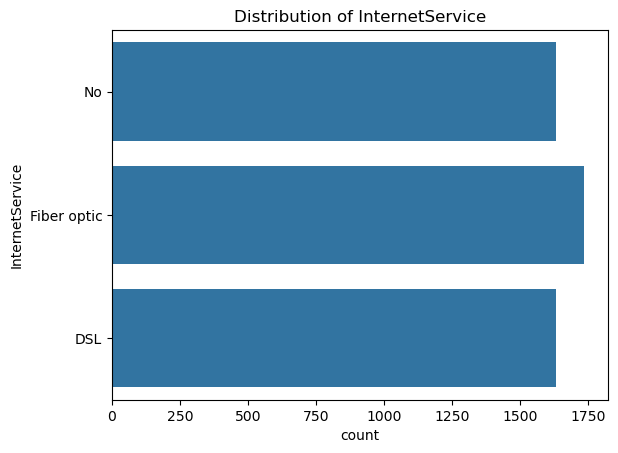

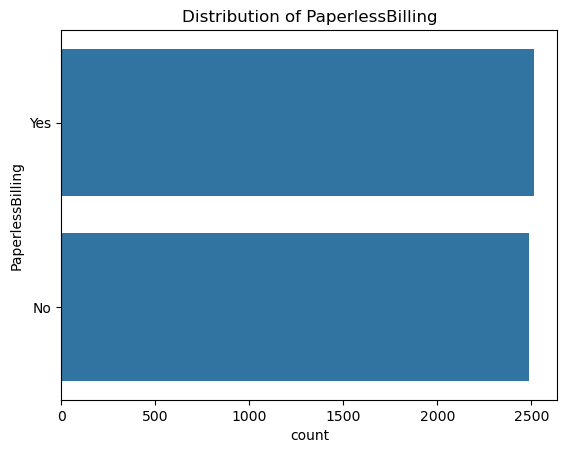

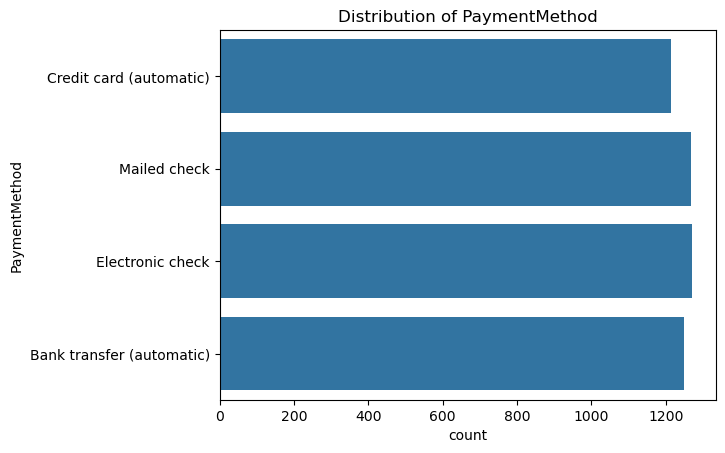

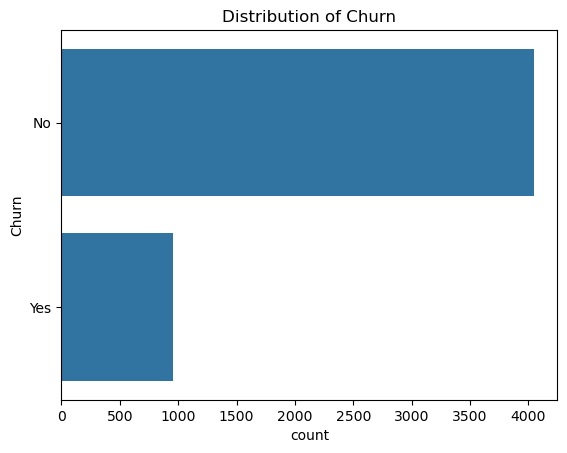

In [7]:
categorical_columns = ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod', 'Churn']
for column in categorical_columns:
    sns.countplot(data[column])
    plt.title(f'Distribution of {column}')
    plt.show()

In [11]:
numeric_data = data.select_dtypes(include=[np.number])

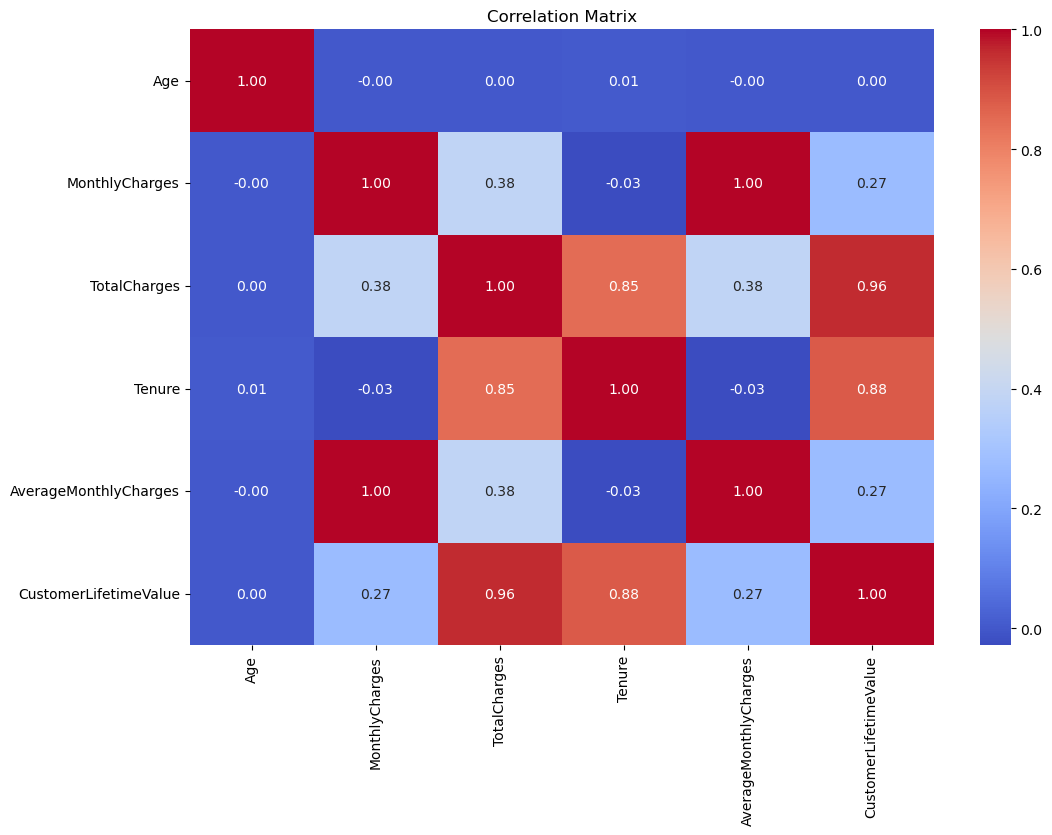

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

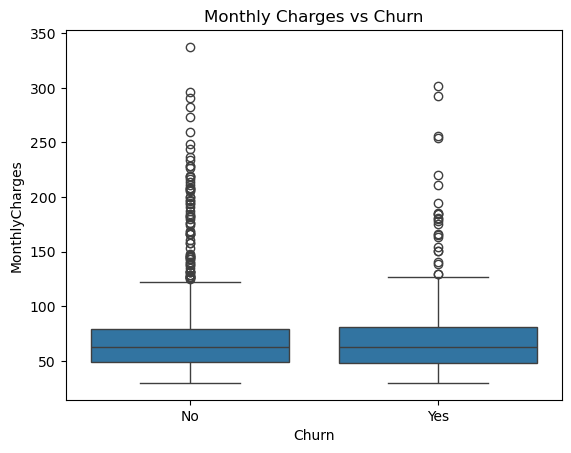

In [17]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title('Monthly Charges vs Churn')
plt.show()

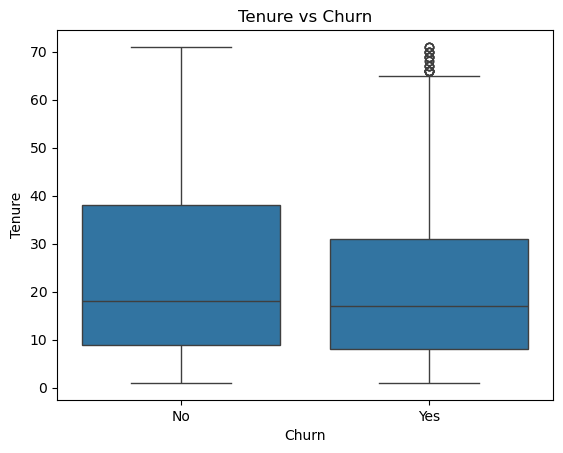

In [19]:
sns.boxplot(x='Churn', y='Tenure', data=data)
plt.title('Tenure vs Churn')
plt.show()

In [25]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

In [29]:
categorical_columns = data.select_dtypes(include=[object]).columns
for column in categorical_columns:
    mode_value = data[column].mode()[0]
    data[column] = data[column].fillna(mode_value)

In [31]:
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [33]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
train, validation = train_test_split(train, test_size=0.25, random_state=42)

In [35]:
train['AverageMonthlyCharges'] = np.round(train['TotalCharges'] / np.maximum(train['Tenure'], 1), 2)
train['CustomerLifetimeValue'] = np.round(train['MonthlyCharges'] * train['Tenure'], 2)

In [43]:
validation['AverageMonthlyCharges'] = np.round(validation['TotalCharges'] / np.maximum(validation['Tenure'], 1), 2)
validation['CustomerLifetimeValue'] = np.round(validation['MonthlyCharges']* validation['Tenure'], 2)

In [45]:
test['AverageMonthlyCharges'] = np.round(test['TotalCharges'] / np.maximum(test['Tenure'], 1), 2)
test['CustomerLifetimeValue'] = np.round(test['MonthlyCharges'] * test['Tenure'], 2)

In [47]:
scaler = StandardScaler()
numerical_columns = ['Age', 'MonthlyCharges', 'TotalCharges', 'Tenure', 'AverageMonthlyCharges', 'CustomerLifetimeValue']
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
validation[numerical_columns] = scaler.transform(validation[numerical_columns])
test[numerical_columns] = scaler.transform(test[numerical_columns])

In [49]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
}

In [51]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [53]:
rf_grid_search = GridSearchCV(models['Random Forest'], param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(train.drop('Churn', axis=1), train['Churn'])

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [55]:
best_rf_model = rf_grid_search.best_estimator_
y_pred = best_rf_model.predict(validation.drop('Churn', axis=1))
print("Validation Classification Report:")
print(classification_report(validation['Churn'], y_pred))

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       794
           1       0.33      0.00      0.01       206

    accuracy                           0.79      1000
   macro avg       0.56      0.50      0.45      1000
weighted avg       0.70      0.79      0.70      1000



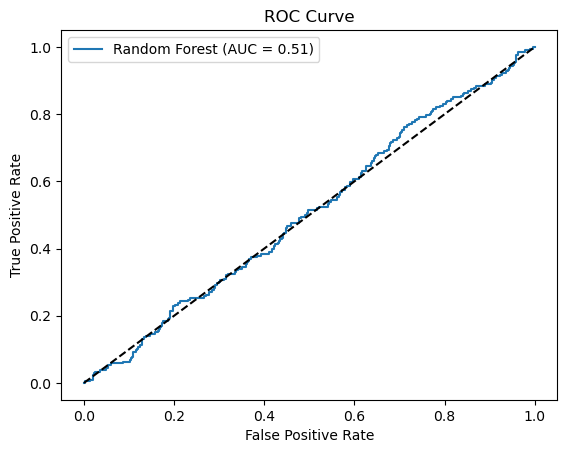

In [57]:
roc_auc = roc_auc_score(validation['Churn'], best_rf_model.predict_proba(validation.drop('Churn', axis=1))[:, 1])
fpr, tpr, thresholds = roc_curve(validation['Churn'], best_rf_model.predict_proba(validation.drop('Churn', axis=1))[:, 1])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

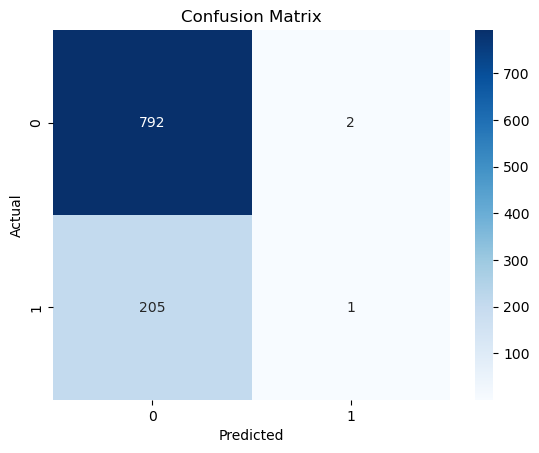

In [59]:
conf_matrix = confusion_matrix(validation['Churn'], y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()